# Reaction Rates

The reaction rates used in these simulations are computed from the Phelps N2 cross section dataset using the two-term solver BOLOS (python version of BOLSIG+). These are equilibrium rates tabulated as functions of the reduced electric field E/N. The mean electron energy for the equilibrium EEDF is also reported.

As long as the energy relaxation time for the given conditions is short compared to the timescales of interest in the simulation, then the EEDF will approximately be in equilibrium. However, these rates will not be accurate when the relaxation time is long compared to relevant timescales for the problem.


In [32]:
# ####################################################
# NOTE ###############################################
# I'm starting from a nepc_cs environment, then doing:
# pip install -e ../nepc
# pip install bolos
# ####################################################
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as co

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
from matplotlib import rcParams
import nepc
from nepc.util import config, parser
from bolos import parser, solver, grid

In [33]:
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 12
rcParams['font.weight'] = 400

rcParams['mathtext.rm'] = 'serif'
rcParams['mathtext.it'] = 'serif:italic'
rcParams['mathtext.bf'] = 'serif:bold'
rcParams['mathtext.fontset'] = 'custom'

In [34]:
cnx, cursor = nepc.connect(local=False)
n_phelps = nepc.Model(cursor, "phelps")

In [35]:
parser.format_model(n_phelps)

AttributeError: module 'bolos.parser' has no attribute 'format_model'

In [37]:
enefile = []
ratefile = []
swarmfile = []
if __name__ == '__main__':
    EoN = np.linspace(0.1,2000)
    press = 101325
    T_k = 300
    ND = press / co.k / T_k
    
    with open('lxcat.txt') as fp:
        processes = parser.parse(fp)
    
    for en in EoN:
        g = grid.LinearGrid(0, 100, 500) # 0-100ev 500 intervals
        bsolver = solver.BoltzmannSolver(g)
        bsolver.load_collisions(processes)
        bsolver.target['N2'].density = 1
        bsolver.kT = T_k * co.k / co.eV
        bsolver.EN = en * solver.TOWNSEND       
        bsolver.init()
        f0 = bsolver.maxwell(2.0)
        f_sol = bsolver.converge(f0, maxn=200, rtol=1e-4)
        mean_energy = bsolver.mean_energy(f_sol)
        electron_temp = bsolver.electron_temperature(f_sol)     
        newgrid = grid.QuadraticGrid(0, 50 * mean_energy, 200)
        bsolver.grid = newgrid
        bsolver.init()

        finterp = bsolver.grid.interpolate(f_sol, g)
        f1 = bsolver.converge(finterp, maxn=200, rtol=1e-5)

        mu = bsolver.mobility(f1) / ND
        diff = bsolver.diffusion(f1) / ND
        k = bsolver.rate(f1, "N2 -> N2^+")

        enefile.append([en, mean_energy])
        ratefile.append([mean_energy,] + [bsolver.rate(f1, p) if bsolver.rate(f1, p) > 1.0e-25 else 0.0e00 for t, p in bsolver.iter_all()])
        swarmfile.append([en, mean_energy, electron_temp, mu, diff, k])

    with open('energy_v_Td_bolos_nepc.txt', 'w') as f:
        np.savetxt(f, np.c_[enefile], delimiter='         ', fmt='%0.3e') # the 0 is as many places as needed
    
    with open('bolos_nepc_rates.txt', 'w') as f:
        np.savetxt(f, np.r_['0,2', ratefile], delimiter='                   ', fmt='%0.3e') 
    
    with open('swarm_file_nepc.txt', 'w') as f:
        np.savetxt(f, np.c_[swarmfile], delimiter='         ', fmt='%0.3e')

ValueError: not enough values to unpack (expected 2, got 1)

In [14]:
cnx, cursor = nepc.connect(local=False)
n_phelps = nepc.Model(cursor, "phelps")

In [16]:
[(p['kind'], p['target'], p['comment'], p.get('threshold'), p.get('product','')) for p in processes]
comment = [p['comment'] for p in processes]
kind = map(str.capitalize, [p['kind'] for p in processes])
reatctant = [p['target'] for p in processes]
product = [p.get('product','N2(X1)') for p in processes]
thresh = [p.get('threshold','0.0') for p in processes]

new_comment = [y for x in comment for y in x.split('\n')]
new_comment = [x for x in new_comment if not x.startswith('UPDATED')]
new_comment = [x for x in new_comment if not x.startswith('COLUMNS')]

# I have a couple options below which are used to extract data
# One is a dictionary of dictionaries, the other is a dictionary of lists
# Using the dictionary of lists right now
d = {}

for i in new_comment:
    #d.setdefault(i.split(': ')[0],set()).add(i.split(': ')[1])
    d.setdefault(i.split(': ')[0],[]).append(i.split(': ')[1].replace(' ',''))

# for n in new_comment:
#     k, v = n.split(': ')
#     if k in d:
#         d[k].add(v)
#         d[k].append(v)
#     else:
#         d[k] = {v}
#         d[k] = [v]

words = [',effective', ',excitation', ',Ionization', ',completeset']
for word in words:
    if word in words:
        d['PROCESS'] = [item.replace('E', 'e') for item in d['PROCESS']]
        d['PROCESS'] = [item.replace('N2+(B2SIGMA)', 'N2(X2:ion:B2SIGMA)') for item in d['PROCESS']]
        d['PROCESS'] = [item.replace('N2(r', 'N2(R') for item in d['PROCESS']]
        d['PROCESS'] = [item.replace('N2+', 'N2(X2:ion)') for item in d['PROCESS']]
        d['PROCESS'] = [item.replace('N2-', 'N2(X1)-') for item in d['PROCESS']]
        d['PROCESS'] = [item.replace(word, '') for item in d['PROCESS']]
        d['PARAM.'] = [item.replace(word, '') for item in d['PARAM.']]
    else:
        break

d['PROCESS'][0] = 'e+N2(X1)->e+N2(X1)'

th = f"{'!Thresh(eV)':<28}{''.join([format(str(x),'<28') for x in [*thresh]])}\n"
re = f"{'!Reaction':<28}{''.join([format(str(x),'<28') for x in d['PROCESS']])}\n"
ty = f"{'!Type':<28}{''.join([format(str(x),'<28') for x in [*kind]])}\n"
units = f"{'!<E> (eV)':<28}{''.join(format('Rate_Constant(m^3/s)','<28'))*26}\n"
sep = f"{'!'}{''.join('-')*len(re)}\n"

string = [th, re, ty, units, sep]

In [17]:
header1 = f"{'E/N (Td)':<18}{'Energy (eV)'}\n"
file1 = 'energy_v_Td_bolos_nepc.txt'
header2 = f"{''.join(string)}"
file2 = 'bolos_nepc_rates.txt'
header3 = f"{'E/N (Td)':<18}{'Energy (eV)':<18}{'Temp (K)':<18}{'Mobility ()':<20}{'Diffusion ()':<20}{'Ionization Rate ()':<20}\n"
file3 = 'swarm_file_nepc.txt'

def WriteHeader(filename, header):
    with open(filename, "r") as f:
        lines = f.readlines()
        f.close()
    lines.insert(0, header)
    with open(filename, "w") as f:
        lines = "".join(lines)  
        f.write(lines)
        f.close()

a = WriteHeader(file1, header1)
b = WriteHeader(file2, header2)
c = WriteHeader(file3, header3)

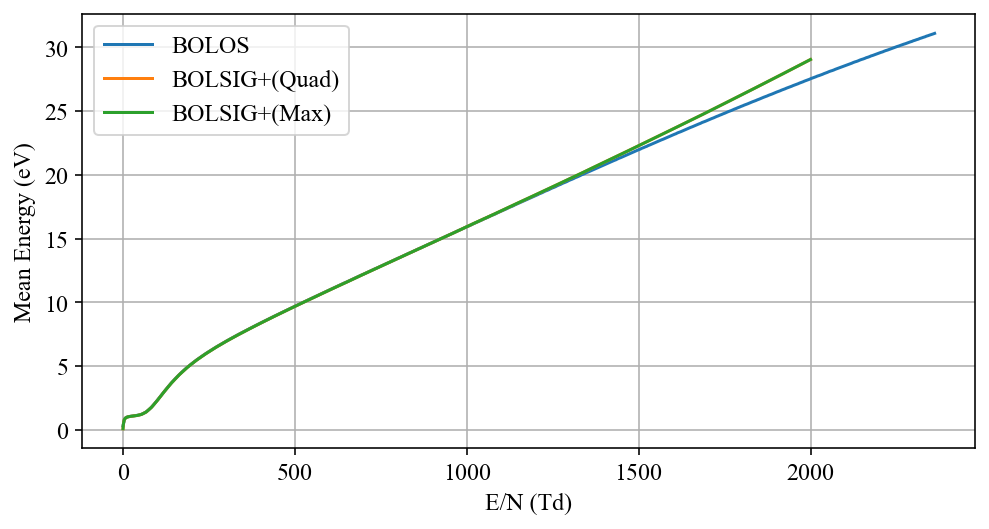

In [19]:
data_bolos = np.loadtxt('energy_v_Td_bolos.txt', skiprows=1)
data_bolsig_quad = np.loadtxt('energy_v_Td_bolsig+quad.txt')
data_bolsig_max = np.loadtxt('energy_v_Td_bolsig+quad.txt')


x1 = data_bolos[:, 0]
y1 = data_bolos[:, 1]
x2 = data_bolsig_quad[:, 0]
y2 = data_bolsig_quad[:, 1]
x3 = data_bolsig_max[:, 0]
y3 = data_bolsig_max[:, 1]
plt.plot(x1, y1)
plt.plot(x2, y2)
plt.plot(x3, y3)
plt.legend(['BOLOS', 'BOLSIG+(Quad)', 'BOLSIG+(Max)'])
plt.xlabel("E/N (Td)")
plt.ylabel("Mean Energy (eV)")
plt.grid()
plt.savefig(f"bolos_v_bolsig+.pdf")

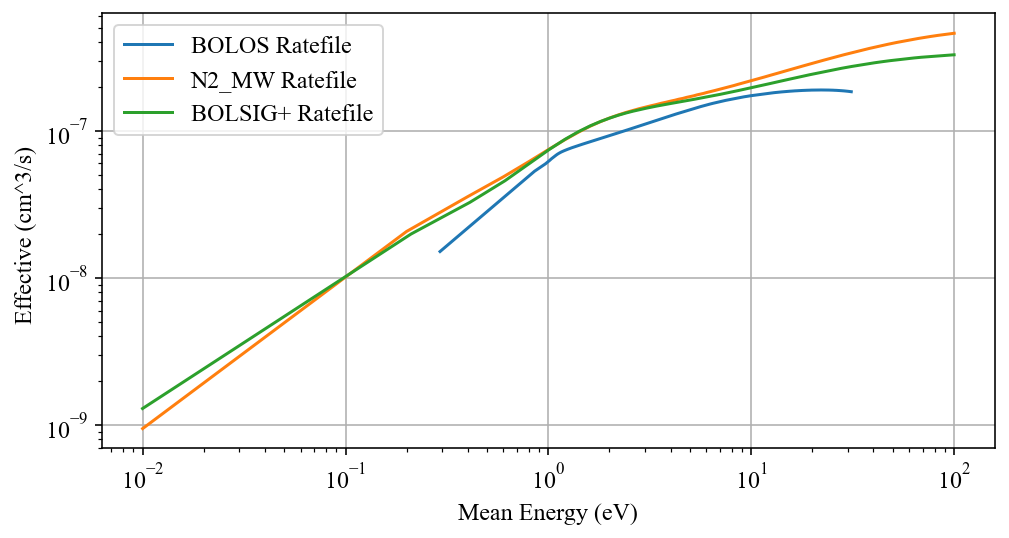

In [20]:
data_bolos_rates = np.loadtxt('bolos_rates.txt', skiprows=5)
data_MW_rates = np.loadtxt('N2_Rates_MW.txt', skiprows=5)
data_bolsig_rates = np.loadtxt('effective_bolsig.txt')

x1 = data_bolos_rates[:, 0]
y1 = data_bolos_rates[:, 1] * 1e+06
x2 = data_MW_rates[:, 0]
y2 = data_MW_rates[:, 1]
x3 = data_bolsig_rates[:, 0]
y3 = data_bolsig_rates[:, 1] * 1e+06
plt.loglog(x1, y1)
plt.loglog(x2, y2)
plt.loglog(x3, y3)
plt.legend(['BOLOS Ratefile', 'N2_MW Ratefile', 'BOLSIG+ Ratefile'])
plt.xlabel("Mean Energy (eV)")
plt.ylabel("Effective (cm^3/s) ")
plt.grid()
plt.savefig(f"compare_effective.pdf")

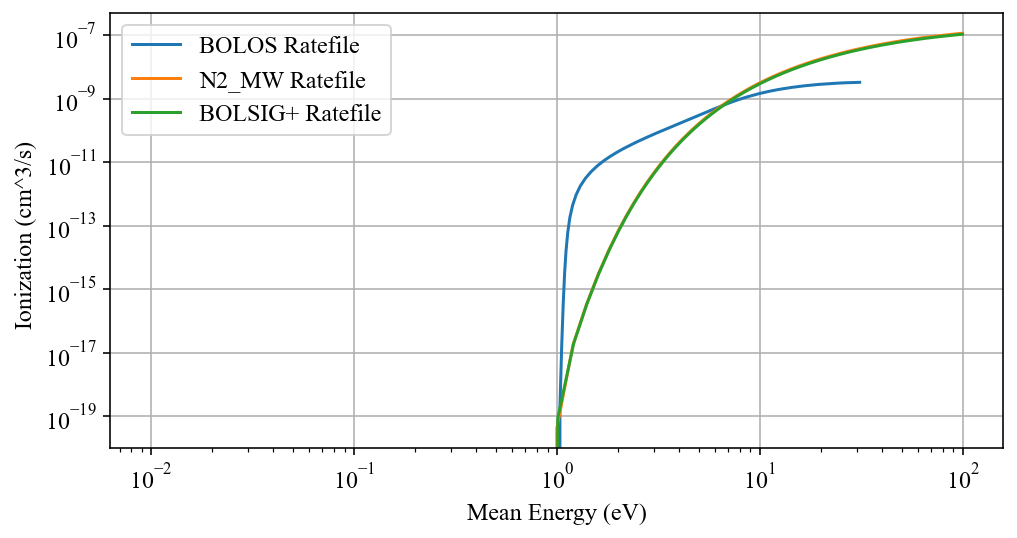

In [21]:
data_bolos_rates = np.loadtxt('bolos_rates.txt', skiprows=5)
data_MW_rates = np.loadtxt('N2_Rates_MW.txt', skiprows=5)
data_bolsig_rates = np.loadtxt('ionization_bolsig.txt')

x1 = data_bolos_rates[:, 0]
y1 = data_bolos_rates[:, 25] * 1e+06
x2 = data_MW_rates[:, 0]
y2 = data_MW_rates[:, 24]
x3 = data_bolsig_rates[:, 0]
y3 = data_bolsig_rates[:, 1] * 1e+06
plt.loglog(x1, y1)
plt.loglog(x2, y2)
plt.loglog(x3, y3)
plt.legend(['BOLOS Ratefile', 'N2_MW Ratefile', 'BOLSIG+ Ratefile'])
plt.xlabel("Mean Energy (eV)")
plt.ylabel("Ionization (cm^3/s) ")
plt.grid()
plt.savefig(f"compare_ionization.pdf")

# Drop partial ionization cross sections

In [78]:
# Drop the extra partial ionization cross section
proc_set = processes[0:2] + processes[3:12] + processes[13:-1]
# proc_set = processes.copy()
[(p['kind'], p.get('product','')) for p in proc_set]

[('EFFECTIVE', ''),
 ('EXCITATION', 'N2(rot)'),
 ('EXCITATION', 'N2(v1res)'),
 ('EXCITATION', 'N2(v2)'),
 ('EXCITATION', 'N2(v3)'),
 ('EXCITATION', 'N2(v4)'),
 ('EXCITATION', 'N2(v5)'),
 ('EXCITATION', 'N2(v6)'),
 ('EXCITATION', 'N2(C3)'),
 ('EXCITATION', 'N2(E3)'),
 ('EXCITATION', "N2(a''1)"),
 ('EXCITATION', 'N2(v7)'),
 ('EXCITATION', 'N2(v8)'),
 ('EXCITATION', 'N2(A3,v0-4)'),
 ('EXCITATION', 'N2(A3,v5-9)'),
 ('EXCITATION', 'N2(B3)'),
 ('EXCITATION', 'N2(W3)'),
 ('EXCITATION', 'N2(A3,v10-)'),
 ('EXCITATION', "N2(B'3)"),
 ('EXCITATION', "N2(a'1)"),
 ('EXCITATION', 'N2(a1)'),
 ('EXCITATION', 'N2(w1)'),
 ('IONIZATION', 'N2^+')]

In [79]:
n_phelps_cs_list = nepc.CustomModel(cursor, "phelps", metadata={'process': 'total'}).cs
n_phelps_cs_list += nepc.CustomModel(cursor, "phelps", metadata={'process': 'excitation'}).cs
n_phelps_cs_list += nepc.CustomModel(cursor, "phelps", metadata={'process': 'excitation_v'}).cs
n_phelps_cs_list += nepc.CustomModel(cursor, "phelps", metadata={'process': 'ionization_total'}).cs
n_phelps_cs_list += nepc.CustomModel(cursor, cs_id_list=[427, 437, 438]).cs

In [80]:
n_phelps_subset = nepc.CustomModel(cs_list=n_phelps_cs_list)

In [81]:
n_phelps_subset.summary()

Number of cross sections in model: 23


,cs_id,specie,lhsA,rhsA,process,reaction,threshold,E_peak,E_upper,sigma_max,lpu,upu
0,425,N2,N2,N2,total,e$^-$ + N${}_2$ $\rightarrow$ N${}_2$ + e$^-$,-1,2.5,10000,3e-19,-1,-1
1,438,N2,N2(X1Sigmag+),N2(B3Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B ${}^3\Pi_g$) + e$^-$,7.35,12,70,2.003e-21,-1,-1
2,439,N2,N2(X1Sigmag+),N2(W3Deltau),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (W ${}^3\Delta_u$) + e$^-$,7.36,16,100,2.546e-21,-1,-1
3,441,N2,N2(X1Sigmag+),N2(Bp3Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (B${}^{'} $ ${}^3\Sigma_u^-$) + e$^-$,8.16,15,70,8.38e-22,-1,-1
4,442,N2,N2(X1Sigmag+),N2(ap1Sigmau-),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a${}^{'}$ ${}^1\Sigma_u^-$) + e$^-$,8.4,15,150,6.97e-22,-1,-1
5,443,N2,N2(X1Sigmag+),N2(a1Pig),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a ${}^1\Pi_g$) + e$^-$,8.55,17,1000,2.023e-21,-1,-1
6,444,N2,N2(X1Sigmag+),N2(w1Deltau),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (w ${}^1\Delta_u$) + e$^-$,8.89,13,50,7.84e-22,-1,-1
7,445,N2,N2(X1Sigmag+),N2(C3Piu),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (C ${}^3\Pi_u$) + e$^-$,11.03,14,100,6.5e-21,-1,-1
8,446,N2,N2(X1Sigmag+),N2(E3Sigmag+),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (E ${}^3\Sigma_g^+$) + e$^-$,11.87,11.92,50,4.96e-22,-1,-1
9,447,N2,N2(X1Sigmag+),N2(ap1Sigmag+),excitation,e$^-$ + N${}_2$ (X ${}^1\Sigma_g^+$) $\rightarrow$ N${}_2$ (a${}^{''}$ ${}^1\Sigma_g^+$) + e$^-$,12.25,20,1000,3.89e-22,-1,-1


In [83]:
# To get to the data in a particular cross section data set, note that this is a list of CS type:
n_phelps_subset.cs


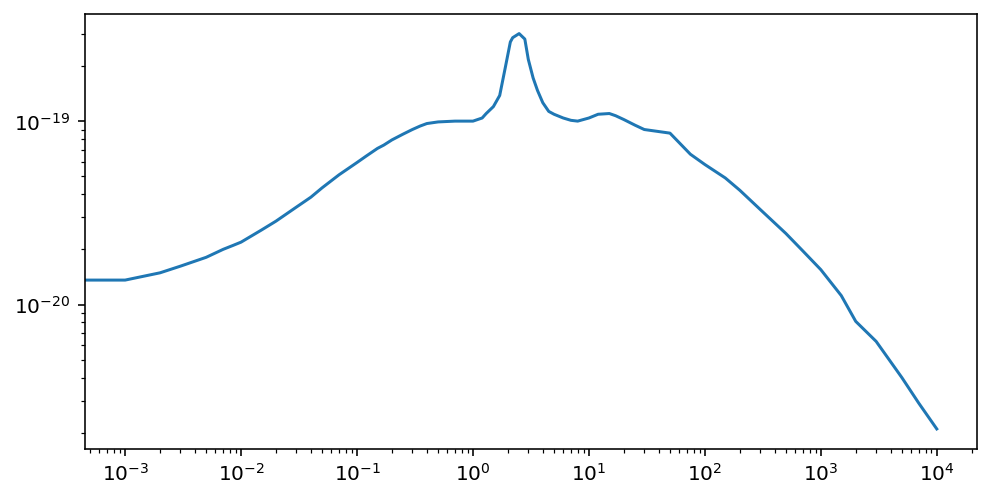

In [85]:
# and each CS type has metadata and data properties. CS.data is a dictionary of e and sigma values:
plt.loglog(n_phelps_subset.cs[0].data['e'], n_phelps_subset.cs[0].data['sigma'])

# Create bolos solver

In [66]:
g = bolos.grid.LinearGrid(0, 60, 400)
bsolver = bolos.solver.BoltzmannSolver(g)
bsolver.load_collisions(proc_set)

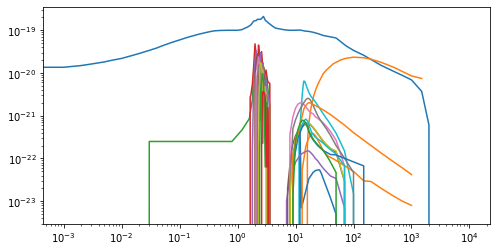

In [67]:
for p in bsolver.target['N2'].everything:
    data = p.data
    plt.loglog(data[:,0], data[:,1])

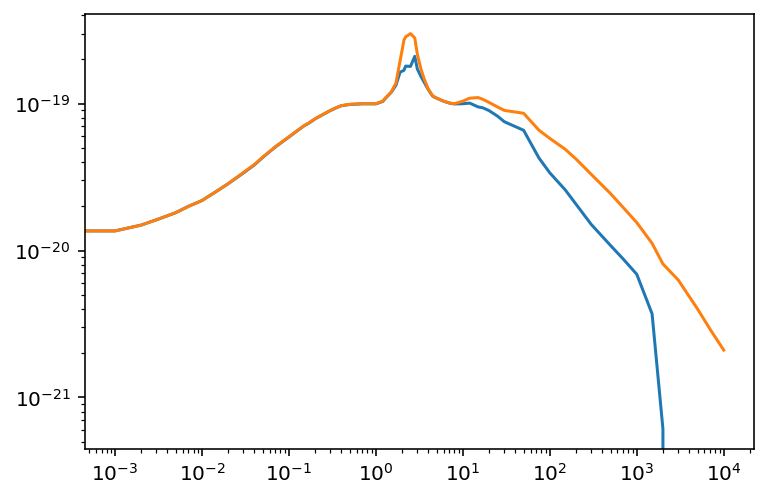

In [9]:
for p in bsolver.target['N2'].elastic:
    data = p.data
    plt.loglog(data[:,0], data[:,1])

data = np.array(processes[0]['data'])
plt.loglog(data[:,0], data[:,1])

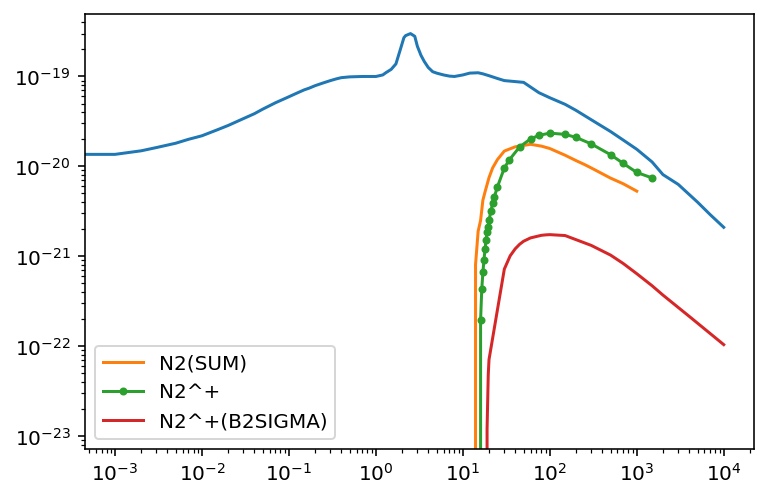

In [10]:
data = np.array(processes[0]['data'])
plt.loglog(data[:,0], data[:,1])

p = processes[12]
data = np.array(p['data'])
plt.loglog(data[:,0], data[:,1], label=p.get('product',''))

p = processes[24]
data = np.array(p['data'])
plt.loglog(data[:,0], data[:,1], '.-', label=p.get('product',''))

p = processes[25]
data = np.array(p['data'])
plt.loglog(data[:,0], data[:,1], label=p.get('product',''))
plt.legend()

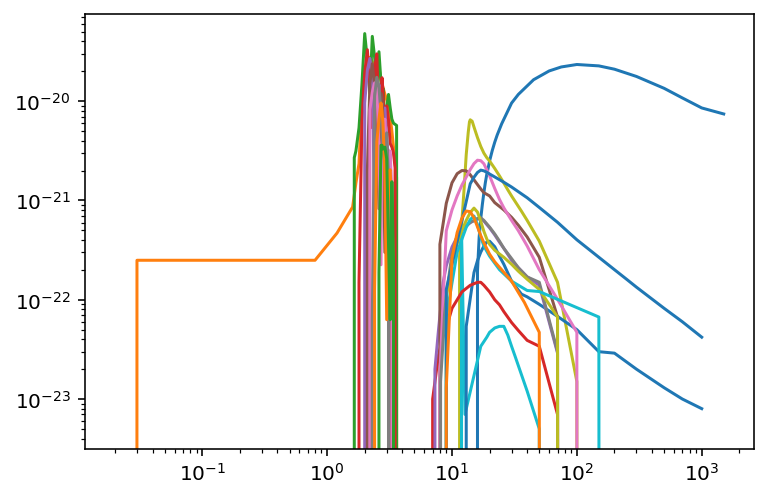

In [11]:
for p in bsolver.target['N2'].inelastic:
    data = p.data
    plt.loglog(data[:,0], data[:,1])

In [146]:
bsolver.target['N2'].density = 1
bsolver.kT = 300 * co.k / co.eV
bsolver.EN = 300.0 * bolos.solver.TOWNSEND
bsolver.init()

In [147]:
f0 = bsolver.maxwell(2.0)

In [148]:
f_sol = bsolver.converge(f0, maxn=50, rtol=1e-5)

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:587: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy) / GAMMA


In [149]:
# second iteration with new grid
mean_energy = bsolver.mean_energy(f_sol)
newgrid = bolos.grid.QuadraticGrid(0, 150 * mean_energy, 200)
bsolver2 = bolos.solver.BoltzmannSolver(newgrid)
bsolver2.load_collisions(proc_set)
bsolver2.target['N2'].density = 1
bsolver2.kT = 300 * co.k / co.eV
bsolver2.EN = 300.0 * bolos.solver.TOWNSEND
bsolver2.init()

f_sol2 = bsolver2.grid.interpolate(f_sol, g)
f_sol2 = bsolver2.converge(f_sol2, maxn=200, rtol=1e-5)

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in true_divide
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: divide by zero encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:190: RuntimeWarning: invalid value encountered in add
  A1 = (  expm1a * ag1 + ag
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:193: RuntimeWarning: invalid value encountered in add
  A2 = (expm1a * (2 * ag1 + ag * ag) + ag * (ag + 2) -
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:194: RuntimeWarning: invalid value encountered in add
  expm1b * (2 * bg1 + bg * bg) - bg * (bg + 2)) / g3
/Users/asrich/anaconda/envs/rigid-beam/

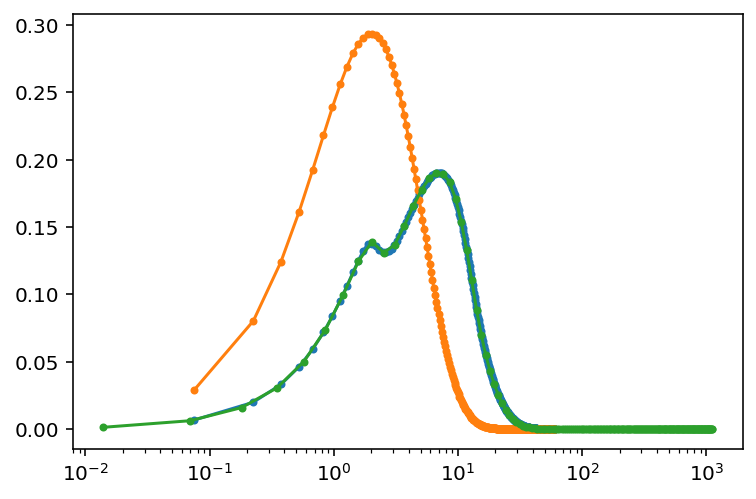

In [150]:
plt.semilogx(bsolver.grid.c, bsolver.grid.c * f_sol, '.-')
plt.semilogx(bsolver.grid.c, bsolver.grid.c * f0, '.-')
plt.semilogx(bsolver2.grid.c, bsolver2.grid.c * f_sol2, '.-')

(0.0, 100.0)

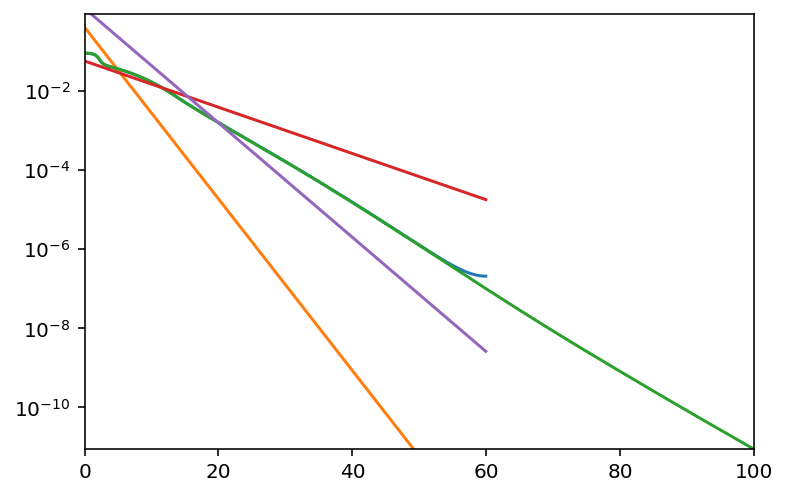

In [151]:
plt.semilogy(bsolver.grid.c, f_sol, '-')
plt.semilogy(bsolver.grid.c, f0, '-')
plt.semilogy(bsolver2.grid.c, f_sol2, '-')

e0 = bsolver2.mean_energy(f_sol2)
f_fit = bsolver.maxwell(e0)
plt.semilogy(bsolver.grid.c, f_fit, '-')

f_guess = bsolver.maxwell(3)
plt.semilogy(bsolver.grid.c, 5.5*f_guess, '-')

maxval = np.max(f_sol2)
minval = 1e-10 * maxval
plt.ylim([minval, 10*maxval])
plt.xlim([0, 100])

In [152]:
mun = bsolver.mobility(f_sol)
diffn = bsolver.diffusion(f_sol)
k = bsolver.rate(f_sol, "N2 -> N2^+")
print(k)

7.012597169178794e-16


/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)


In [153]:
print(f"The mean electron energy is {bsolver.mean_energy(f_sol)}")
for target, proc in bsolver.iter_all():
    print("The rate of %s is %g" % (str(proc), bsolver.rate(f_sol, proc)))

The mean electron energy is 7.436326317847588
The rate of {ELASTIC: N2 } is 1.62152e-13
The rate of {IONIZATION: N2 -> N2^+} is 7.0126e-16
The rate of {EXCITATION: N2 -> N2(rot)} is 2.17646e-15
The rate of {EXCITATION: N2 -> N2(v1res)} is 2.58502e-15
The rate of {EXCITATION: N2 -> N2(v2)} is 1.54187e-15
The rate of {EXCITATION: N2 -> N2(v3)} is 1.03975e-15
The rate of {EXCITATION: N2 -> N2(v4)} is 7.0278e-16
The rate of {EXCITATION: N2 -> N2(v5)} is 5.83413e-16
The rate of {EXCITATION: N2 -> N2(v6)} is 4.8577e-16
The rate of {EXCITATION: N2 -> N2(C3)} is 1.43697e-15
The rate of {EXCITATION: N2 -> N2(E3)} is 2.67013e-17
The rate of {EXCITATION: N2 -> N2(a''1)} is 8.48824e-17
The rate of {EXCITATION: N2 -> N2(v7)} is 2.60959e-16
The rate of {EXCITATION: N2 -> N2(v8)} is 1.23352e-16
The rate of {EXCITATION: N2 -> N2(A3,v0-4)} is 8.496e-17
The rate of {EXCITATION: N2 -> N2(A3,v5-9)} is 3.51916e-16
The rate of {EXCITATION: N2 -> N2(B3)} is 1.13967e-15
The rate of {EXCITATION: N2 -> N2(W3)} 

In [154]:
print(f"The mean electron energy is {bsolver2.mean_energy(f_sol2)}")
for target, proc in bsolver2.iter_all():
    print("The rate of %s is %g" % (str(proc), bsolver2.rate(f_sol2, proc)))

The mean electron energy is 7.421555146587588
The rate of {ELASTIC: N2 } is 1.62497e-13
The rate of {IONIZATION: N2 -> N2^+} is 7.10663e-16
The rate of {EXCITATION: N2 -> N2(rot)} is 2.1982e-15
The rate of {EXCITATION: N2 -> N2(v1res)} is 2.57023e-15
The rate of {EXCITATION: N2 -> N2(v2)} is 1.56785e-15
The rate of {EXCITATION: N2 -> N2(v3)} is 1.08552e-15
The rate of {EXCITATION: N2 -> N2(v4)} is 7.06797e-16
The rate of {EXCITATION: N2 -> N2(v5)} is 5.68865e-16
The rate of {EXCITATION: N2 -> N2(v6)} is 4.84842e-16
The rate of {EXCITATION: N2 -> N2(C3)} is 1.44584e-15
The rate of {EXCITATION: N2 -> N2(E3)} is 2.80245e-17
The rate of {EXCITATION: N2 -> N2(a''1)} is 8.56138e-17
The rate of {EXCITATION: N2 -> N2(v7)} is 2.74819e-16
The rate of {EXCITATION: N2 -> N2(v8)} is 1.26081e-16
The rate of {EXCITATION: N2 -> N2(A3,v0-4)} is 8.53372e-17
The rate of {EXCITATION: N2 -> N2(A3,v5-9)} is 3.53534e-16
The rate of {EXCITATION: N2 -> N2(B3)} is 1.14402e-15
The rate of {EXCITATION: N2 -> N2(W

# Computing rate tables

This looks pretty good. To get rate tables from this, we can create a function which computes the EEDF using this two step process. And then tabulate the rates.

I am mostly interested to see how these rates compare to those computed using a Maxwellian with the same mean energy (or same high energy slope? or some sort of bi-Maxwellian?). Perhaps the Maxwellian rates can be used to extend the rate tables?

In [155]:
def compute_eedf(reduced_field, processes, energy_guess, max_energy=800):
    # Initial guess is based on a Maxwellian
    max_e = min(max_energy, 150 * energy_guess)
    g = bolos.grid.LinearGrid(0, max_e, 400)
    bsolver = bolos.solver.BoltzmannSolver(g)
    bsolver.load_collisions(processes)
    bsolver.target['N2'].density = 1
    bsolver.kT = 300 * co.k / co.eV
    bsolver.EN = reduced_field * bolos.solver.TOWNSEND
    bsolver.init()
    f0 = bsolver.maxwell(energy_guess)
    
    # Compute first iteration
    f_sol = bsolver.converge(f0, maxn=50, rtol=1e-5)
    
    # Compute second iteration
    mean_energy = bsolver.mean_energy(f_sol)
    max_e = min(max_energy, 150 * mean_energy)
    newgrid = bolos.grid.QuadraticGrid(0, max_e, 800)
    bsolver2 = bolos.solver.BoltzmannSolver(newgrid)
    bsolver2.load_collisions(proc_set)
    bsolver2.target['N2'].density = 1
    bsolver2.kT = 300 * co.k / co.eV
    bsolver2.EN = reduced_field * bolos.solver.TOWNSEND
    bsolver2.init()

    f_sol2 = bsolver2.grid.interpolate(f_sol, g)
    f_sol2 = bsolver2.converge(f_sol2, maxn=2000, rtol=1e-7)
    
    return (f_sol2, bsolver2)

In [156]:
f_new, sol_new = compute_eedf(300, proc_set, 2)

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:587: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy) / GAMMA
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in true_divide
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: divide by zero encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:190: RuntimeWarning: invalid value encountered in add
  A1 = (  expm1a * ag1 + ag
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:190: RuntimeWarning: invalid value encountered in subtract
  A1 = (  expm1a * ag1 + ag
/Users/asrich/anaconda/envs/rigid-beam/l

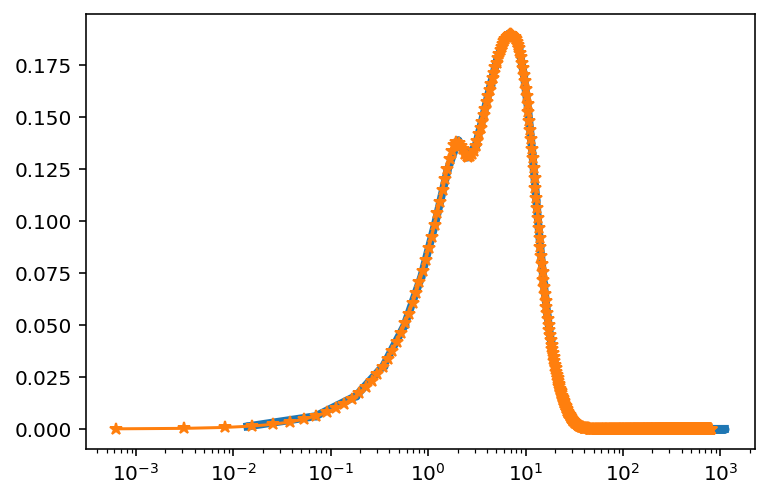

In [157]:
plt.semilogx(bsolver2.grid.c, bsolver2.grid.c * f_sol2, '.-', lw=4)
plt.semilogx(sol_new.grid.c, sol_new.grid.c * f_new, '*-')

In [158]:
# Load mean energy from prior Bolsig run, and do a comparison
bolsig = np.loadtxt('energy_vs_Td.txt', skiprows=1)

In [159]:
red_field_values = bolsig[:,0]

In [160]:
solvers = []
solutions = []
energies = []
energy_guess = 2
for eon in red_field_values:
    f_new, sol_new = compute_eedf(eon, proc_set, energy_guess)
    solvers.append(sol_new)
    solutions.append(f_new)
    energies.append(sol_new.mean_energy(f_new))
    energy_guess = energies[-1]

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:587: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy) / GAMMA
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: divide by zero encountered in true_divide
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: divide by zero encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:190: RuntimeWarning: invalid value encountered in add
  A1 = (  expm1a * ag1 + ag
/Users/as

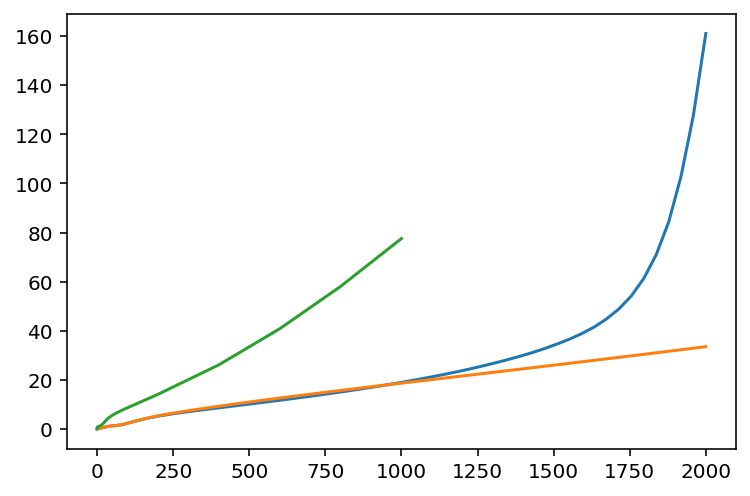

In [161]:
lsp = np.loadtxt('../LSP_tables/energy_vs_Td.txt', skiprows=1)

plt.plot(red_field_values, bolsig[:,1])
plt.plot(red_field_values, energies)

plt.plot(lsp[:,0], lsp[:,1])
# plt.xlim([0,1000])
# plt.ylim([0,40])

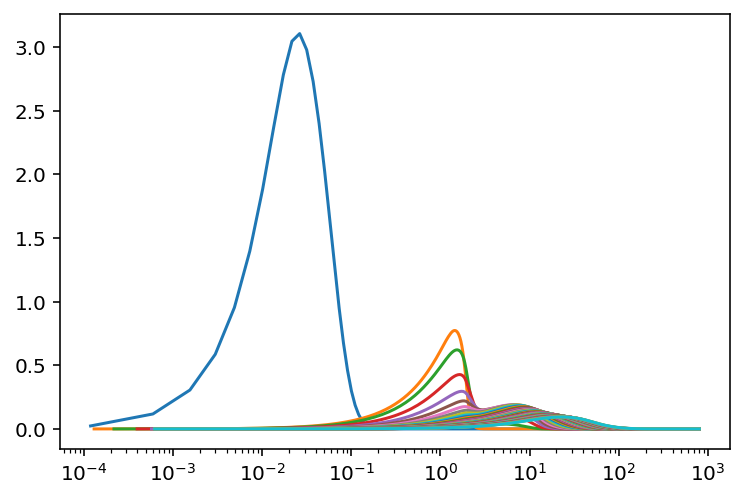

In [162]:
for sol_new, f_new in zip(solvers, solutions):
    plt.semilogx(sol_new.grid.c, sol_new.grid.c * f_new, '-')

(0.0, 500.0)

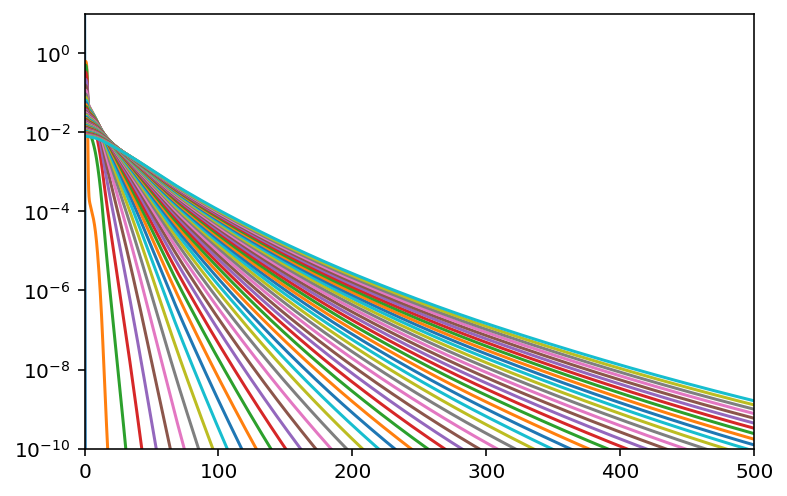

In [163]:
for sol_new, f_new in zip(solvers, solutions):
    plt.semilogy(sol_new.grid.c, f_new, '-')

plt.ylim([1e-10, 10])
plt.xlim([0, 500])

(0.0, 20.0)

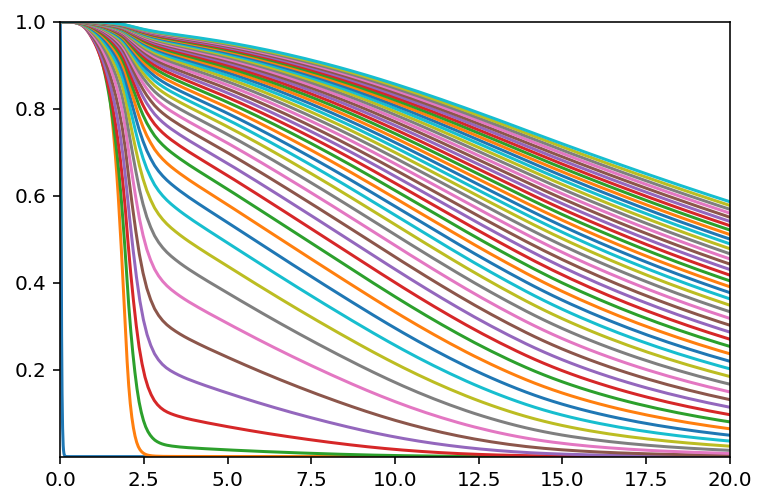

In [164]:
for sol_new, f_new in zip(solvers, solutions):
    plt.plot(sol_new.grid.c, f_new/f_new[0], '-')

plt.ylim([1e-6, 1])
plt.xlim([0, 20])

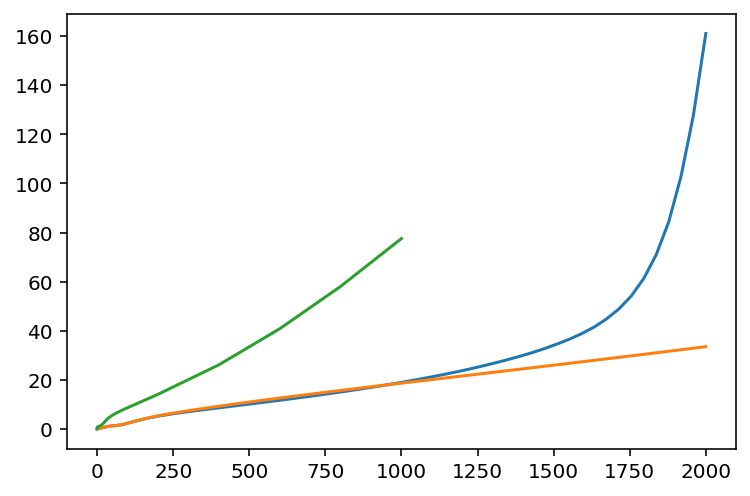

In [165]:
plt.plot(red_field_values, bolsig[:,1])
plt.plot(red_field_values, energies)

plt.plot(lsp[:,0], lsp[:,1])

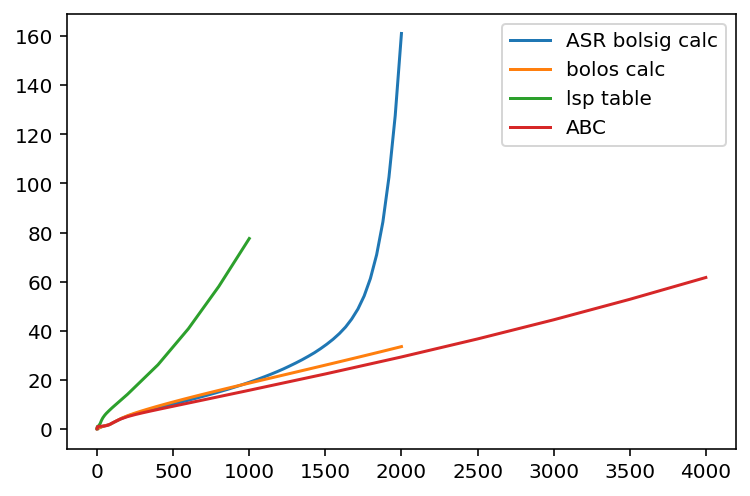

In [166]:
abc_field = [0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0,  10.0,
                    15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0,
                    70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 150.0, 200.0, 250.0,
                    300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 
                    750.0, 800.0, 850.0, 900.0, 950.0, 1000.0, 1500.0, 2000.0, 2500.0, 
                    3000.0, 3500.0, 4000.0]
abc_temp = [0.0,  0.388, 0.513, 0.559, 0.585, 0.602, 0.616, 0.626, 0.634, 
                     0.642, 0.648, 0.670, 0.684, 0.696, 0.707, 0.731, 0.718, 0.748, 
                     0.773, 0.806, 0.850, 0.908, 0.978, 1.059, 1.152, 1.252, 1.359, 
                     1.470, 1.583, 2.598, 3.315, 3.872, 4.360, 4.818, 5.263, 5.701, 
                     6.136, 6.570, 7.004, 7.437, 7.870, 8.304, 8.738, 9.172, 9.607, 
                     10.04, 10.48, 14.91, 19.53, 24.42, 29.62, 35.18, 41.11]
abc_energy = np.array(abc_temp) * 3/2


plt.plot(red_field_values, bolsig[:,1], label='ASR bolsig calc')
plt.plot(red_field_values, energies, label='bolos calc')
plt.plot(lsp[:,0], lsp[:,1], label='lsp table')
plt.plot(abc_field, abc_energy, label='ABC')
plt.legend()

In [167]:
print(f"The mean electron energy is {sol_new.mean_energy(f_new)}")
for target, proc in sol_new.iter_elastic():
    print("The rate of %s is %g" % (str(proc), sol_new.rate(f_new, proc)))

The mean electron energy is 33.51021427116622
The rate of {ELASTIC: N2 } is 2.27123e-13


In [168]:
kmom_bolos = []
for sol_new, f_new in zip(solvers, solutions):
    tmp = 0
    # for target, proc in sol_new.iter_elastic():
    for target, proc in sol_new.iter_momentum():
        tmp += sol_new.rate(f_new, proc)
    kmom_bolos.append(tmp * 1e6)

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:193: RuntimeWarning: invalid value encountered in true_divide
  A2 = (expm1a * (2 * ag1 + ag * ag) + ag * (ag + 2) -
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:190: RuntimeWarning: invalid value encountered in true_divide
  A1 = (  expm1a * ag1 + ag
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/process.py:193: RuntimeWarning: invalid value encountered in true_divide
  A2 = (expm1a * (2 * ag1 + ag * ag) + ag * (ag + 2) -
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda

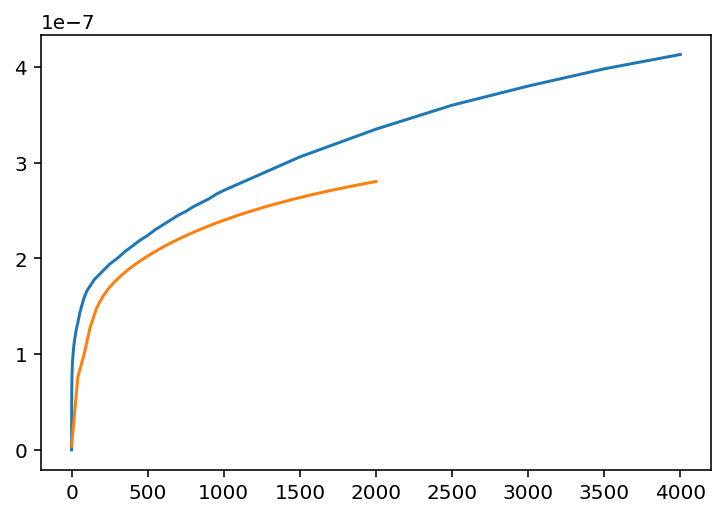

In [169]:
kmom2T = [0.0, 5.40e-8, 7.11e-8, 7.89e-8, 8.40e-8, 8.78e-8, 9.10e-8, 
                    9.38e-8, 9.62e-8, 9.84e-8, 1.01e-7, 1.09e-7, 1.15e-7, 1.20e-7, 
                    1.25e-7, 1.29e-7, 1.32e-7, 1.36e-7, 1.40e-7, 1.44e-7, 1.46e-7, 
                    1.50e-7, 1.52e-7, 1.55e-7, 1.58e-7, 1.60e-7, 1.62e-7, 1.64e-7, 
                    1.66e-7, 1.78e-7, 1.86e-7, 1.94e-7, 2.00e-7, 2.07e-7, 2.13e-7, 
                    2.19e-7, 2.24e-7, 2.30e-7, 2.35e-7, 2.40e-7, 2.45e-7, 2.49e-7, 
                    2.54e-7, 2.58e-7, 2.62e-7, 2.67e-7, 2.71e-7, 3.06e-7, 3.35e-7, 
                    3.60e-7, 3.80e-7, 3.98e-7, 4.13e-7]
plt.plot(abc_field, kmom2T)
plt.plot(red_field_values, np.array(kmom_bolos) )

In [170]:
sbs_mom = [4.903E-09,
4.997E-09,
5.095E-09,
5.195E-09,
5.299E-09,
5.407E-09,
5.518E-09,
5.633E-09,
5.751E-09,
5.873E-09,
5.999E-09,
6.130E-09,
6.264E-09,
6.403E-09,
6.547E-09,
6.695E-09,
6.848E-09,
7.006E-09,
7.169E-09,
7.336E-09,
7.509E-09,
7.687E-09,
7.871E-09,
8.060E-09,
8.254E-09,
8.458E-09,
8.664E-09,
8.877E-09,
9.095E-09,
9.319E-09,
9.550E-09,
9.787E-09,
1.003E-08,
1.028E-08,
1.053E-08,
1.080E-08,
1.106E-08,
1.134E-08,
1.162E-08,
1.190E-08,
1.220E-08,
1.249E-08,
1.280E-08,
1.310E-08,
1.342E-08,
1.374E-08,
1.406E-08,
1.439E-08,
1.472E-08,
1.506E-08,
1.540E-08,
1.574E-08,
1.609E-08,
1.645E-08,
1.680E-08,
1.716E-08,
1.752E-08,
1.789E-08,
1.826E-08,
1.863E-08,
1.900E-08,
1.939E-08,
1.977E-08,
2.015E-08,
2.053E-08,
2.092E-08,
2.131E-08,
2.170E-08,
2.210E-08,
2.250E-08,
2.290E-08,
2.330E-08,
2.371E-08,
2.412E-08,
2.454E-08,
2.495E-08,
2.537E-08,
2.580E-08,
2.623E-08,
2.666E-08,
2.710E-08,
2.754E-08,
2.798E-08,
2.843E-08,
2.888E-08,
2.934E-08,
2.980E-08,
3.026E-08,
3.073E-08,
3.120E-08,
3.168E-08,
3.216E-08,
3.265E-08,
3.314E-08,
3.364E-08,
3.413E-08,
3.464E-08,
3.515E-08,
3.566E-08,
3.618E-08,
3.670E-08,
3.722E-08,
3.775E-08,
3.828E-08,
3.881E-08,
3.935E-08,
3.989E-08,
4.043E-08,
4.098E-08,
4.153E-08,
4.208E-08,
4.263E-08,
4.319E-08,
4.375E-08,
4.431E-08,
4.487E-08,
4.543E-08,
4.599E-08,
4.655E-08,
4.712E-08,
4.768E-08,
4.825E-08,
4.881E-08,
4.937E-08,
4.994E-08,
5.050E-08,
5.107E-08,
5.163E-08,
5.219E-08,
5.275E-08,
5.331E-08,
5.387E-08,
5.443E-08,
5.499E-08,
5.554E-08,
5.610E-08,
5.665E-08,
5.721E-08,
5.776E-08,
5.831E-08,
5.886E-08,
5.941E-08,
5.996E-08,
6.050E-08,
6.105E-08,
6.160E-08,
6.214E-08,
6.269E-08,
6.323E-08,
6.378E-08,
6.432E-08,
6.486E-08,
6.541E-08,
6.595E-08,
6.650E-08,
6.704E-08,
6.759E-08,
6.813E-08,
6.868E-08,
6.923E-08,
6.977E-08,
7.032E-08,
7.087E-08,
7.143E-08,
7.198E-08,
7.253E-08,
7.309E-08,
7.365E-08,
7.421E-08,
7.477E-08,
7.533E-08,
7.590E-08,
7.646E-08,
7.703E-08,
7.760E-08,
7.817E-08,
7.875E-08,
7.933E-08,
7.990E-08,
8.048E-08,
8.107E-08,
8.165E-08,
8.224E-08,
8.283E-08,
8.341E-08,
8.401E-08,
8.460E-08,
8.520E-08,
8.579E-08,
8.639E-08,
8.699E-08,
8.759E-08,
8.820E-08,
8.880E-08,
8.940E-08,
9.001E-08,
9.062E-08,
9.123E-08,
9.184E-08,
9.245E-08,
9.306E-08,
9.367E-08,
9.428E-08,
9.490E-08,
9.551E-08,
9.613E-08,
9.674E-08,
9.736E-08,
9.797E-08,
9.858E-08,
9.920E-08,
9.981E-08,
1.004E-07,
1.010E-07,
1.016E-07,
1.023E-07,
1.029E-07,
1.035E-07,
1.041E-07,
1.047E-07,
1.053E-07,
1.059E-07,
1.065E-07,
1.071E-07,
1.077E-07,
1.083E-07,
1.089E-07,
1.095E-07,
1.101E-07,
1.107E-07,
1.114E-07,
1.119E-07,
1.128E-07,
1.134E-07,
1.140E-07,
1.146E-07,
1.152E-07,
1.158E-07,
1.165E-07,
1.171E-07,
1.177E-07,
1.182E-07,
1.188E-07,
1.194E-07,
1.200E-07,
1.198E-07,
1.204E-07,
1.210E-07,
1.215E-07,
1.221E-07,
1.227E-07,
1.232E-07,
1.238E-07,
1.243E-07,
1.249E-07,
1.255E-07,
1.270E-07,
1.276E-07,
1.282E-07,
1.287E-07,
1.293E-07,
1.299E-07,
1.305E-07,
1.311E-07,
1.316E-07,
1.322E-07,
1.328E-07,
1.334E-07,
1.335E-07,
1.341E-07,
1.347E-07,
1.353E-07,
1.359E-07,
1.365E-07,
1.371E-07,
1.377E-07,
1.383E-07,
1.390E-07,
1.396E-07,
1.398E-07,
1.404E-07,
1.411E-07,
1.418E-07,
1.424E-07,
1.431E-07,
1.438E-07,
1.445E-07,
1.452E-07,
1.459E-07,
1.467E-07,
1.488E-07,
1.495E-07,
1.503E-07,
1.510E-07,
1.517E-07,
1.525E-07,
1.532E-07,
1.540E-07,
1.548E-07,
1.555E-07,
1.556E-07,
1.564E-07,
1.571E-07,
1.579E-07,
1.587E-07,
1.595E-07,
1.602E-07,
1.610E-07,
1.617E-07,
1.625E-07,
1.624E-07,
1.631E-07,
1.639E-07,
1.647E-07,
1.654E-07,
1.662E-07,
1.669E-07,
1.676E-07,
1.684E-07,
1.691E-07,
1.706E-07,
1.713E-07,
1.720E-07,
1.726E-07,
1.733E-07,
1.739E-07,
1.746E-07,
1.752E-07,
1.759E-07,
1.762E-07,
1.769E-07,
1.775E-07,
1.782E-07,
1.788E-07,
1.795E-07,
1.801E-07,
1.807E-07,
1.814E-07,
1.823E-07,
1.829E-07,
1.836E-07,
1.842E-07,
1.849E-07,
1.855E-07,
1.862E-07,
1.869E-07,
1.876E-07,
1.887E-07,
1.894E-07,
1.901E-07,
1.908E-07,
1.914E-07,
1.921E-07,
1.929E-07,
1.936E-07,
1.935E-07,
1.943E-07,
1.951E-07,
1.959E-07,
1.967E-07,
1.975E-07,
1.983E-07,
1.991E-07,
2.001E-07,
2.009E-07,
2.018E-07,
2.026E-07,
2.035E-07,
2.044E-07,
2.053E-07,
2.064E-07,
2.073E-07,
2.082E-07,
2.092E-07,
2.102E-07,
2.111E-07,
2.121E-07,
2.131E-07,
2.142E-07,
2.152E-07,
2.163E-07,
2.174E-07,
2.184E-07,
2.196E-07,
2.209E-07,
2.220E-07,
2.232E-07,
2.243E-07,
2.255E-07,
2.267E-07,
2.277E-07,
2.289E-07,
2.302E-07,
2.315E-07,
2.328E-07,
2.341E-07,
2.354E-07,
2.370E-07,
2.384E-07,
2.397E-07,
2.412E-07,
2.426E-07,
2.439E-07,
2.454E-07,
2.469E-07,
2.484E-07,
2.499E-07,
2.514E-07,
2.530E-07,
2.546E-07,
2.562E-07,
2.578E-07,
2.594E-07,
2.610E-07,
2.627E-07,
2.644E-07,
2.661E-07,
2.678E-07,
2.695E-07,
2.712E-07,
2.730E-07,
2.749E-07,
2.767E-07,
2.787E-07,
2.805E-07,
2.824E-07,
2.843E-07,
2.863E-07,
2.883E-07,
2.903E-07,
2.923E-07,
2.943E-07,
2.963E-07,
2.983E-07,
3.004E-07,
3.025E-07,
3.046E-07,
3.067E-07,
3.088E-07,
3.110E-07,
3.132E-07,
3.154E-07,
3.176E-07,
3.198E-07,
3.221E-07,
3.243E-07,
3.266E-07,
3.289E-07,
3.312E-07,
3.336E-07,
3.358E-07,
3.382E-07,
3.405E-07,
3.429E-07,
3.452E-07,
3.476E-07,
3.500E-07,
3.524E-07,
3.549E-07,
3.574E-07,
3.598E-07,
3.623E-07,
3.648E-07,
3.673E-07,
3.697E-07,
3.722E-07,
3.744E-07,
3.769E-07,
3.794E-07,
3.819E-07,
3.845E-07,
3.870E-07,
3.895E-07,
3.920E-07,
3.945E-07,
3.969E-07,
3.994E-07,
4.019E-07,
4.043E-07,
4.067E-07,
4.092E-07,
4.115E-07,
4.139E-07,
4.164E-07,
4.187E-07,
4.210E-07,
4.233E-07,
4.257E-07,
4.280E-07,
4.302E-07,
4.325E-07,
4.348E-07,
4.371E-07,
4.392E-07,
4.414E-07,
4.435E-07,
4.454E-07,
4.475E-07,
4.495E-07,
4.515E-07,
4.533E-07,
]
sbs_energy = [0.0336,
0.0344,
0.0352,
0.0360,
0.0368,
0.0377,
0.0385,
0.0395,
0.0404,
0.0414,
0.0424,
0.0434,
0.0445,
0.0456,
0.0468,
0.0479,
0.0491,
0.0504,
0.0517,
0.0530,
0.0544,
0.0558,
0.0573,
0.0588,
0.0603,
0.0619,
0.0635,
0.0652,
0.0670,
0.0687,
0.0706,
0.0724,
0.0744,
0.0763,
0.0783,
0.0804,
0.0825,
0.0847,
0.0869,
0.0891,
0.0914,
0.0938,
0.0962,
0.0986,
0.1011,
0.1036,
0.1061,
0.1087,
0.1113,
0.1140,
0.1167,
0.1194,
0.1222,
0.1250,
0.1279,
0.1307,
0.1337,
0.1366,
0.1397,
0.1427,
0.1458,
0.1489,
0.1521,
0.1554,
0.1587,
0.1620,
0.1654,
0.1689,
0.1724,
0.1760,
0.1797,
0.1834,
0.1872,
0.1911,
0.1951,
0.1991,
0.2032,
0.2075,
0.2118,
0.2162,
0.2207,
0.2253,
0.2300,
0.2348,
0.2397,
0.2447,
0.2498,
0.2551,
0.2604,
0.2659,
0.2714,
0.2771,
0.2829,
0.2889,
0.2949,
0.3010,
0.3073,
0.3136,
0.3201,
0.3267,
0.3333,
0.3401,
0.3470,
0.3539,
0.3609,
0.3680,
0.3752,
0.3825,
0.3898,
0.3972,
0.4046,
0.4121,
0.4196,
0.4271,
0.4347,
0.4423,
0.4499,
0.4576,
0.4652,
0.4728,
0.4805,
0.4881,
0.4957,
0.5032,
0.5108,
0.5183,
0.5258,
0.5332,
0.5406,
0.5480,
0.5553,
0.5626,
0.5698,
0.5769,
0.5840,
0.5911,
0.5981,
0.6050,
0.6118,
0.6186,
0.6254,
0.6320,
0.6386,
0.6452,
0.6517,
0.6581,
0.6644,
0.6707,
0.6770,
0.6832,
0.6893,
0.6954,
0.7014,
0.7073,
0.7132,
0.7190,
0.7248,
0.7306,
0.7362,
0.7419,
0.7474,
0.7530,
0.7584,
0.7639,
0.7692,
0.7746,
0.7798,
0.7851,
0.7903,
0.7954,
0.8005,
0.8055,
0.8105,
0.8154,
0.8203,
0.8252,
0.8300,
0.8347,
0.8394,
0.8441,
0.8487,
0.8532,
0.8577,
0.8622,
0.8666,
0.8709,
0.8752,
0.8795,
0.8837,
0.8878,
0.8919,
0.8960,
0.8999,
0.9039,
0.9078,
0.9116,
0.9154,
0.9191,
0.9228,
0.9264,
0.9300,
0.9335,
0.9370,
0.9404,
0.9438,
0.9471,
0.9504,
0.9536,
0.9568,
0.9599,
0.9630,
0.9661,
0.9691,
0.9720,
0.9749,
0.9778,
0.9806,
0.9834,
0.9861,
0.9888,
0.9915,
0.9941,
0.9967,
0.9993,
 1.002,
 1.004,
 1.007,
 1.009,
 1.011,
 1.014,
 1.016,
 1.019,
 1.021,
 1.023,
 1.026,
 1.028,
 1.030,
 1.032,
 1.035,
 1.037,
 1.039,
 1.041,
 1.043,
 1.045,
 1.047,
 1.049,
 1.051,
 1.053,
 1.055,
 1.057,
 1.059,
 1.061,
 1.063,
 1.065,
 1.067,
 1.069,
 1.072,
 1.074,
 1.076,
 1.078,
 1.080,
 1.082,
 1.085,
 1.087,
 1.089,
 1.092,
 1.094,
 1.097,
 1.100,
 1.103,
 1.106,
 1.109,
 1.113,
 1.116,
 1.120,
 1.125,
 1.129,
 1.134,
 1.139,
 1.145,
 1.151,
 1.158,
 1.166,
 1.174,
 1.183,
 1.193,
 1.203,
 1.215,
 1.228,
 1.242,
 1.256,
 1.273,
 1.291,
 1.311,
 1.332,
 1.356,
 1.381,
 1.408,
 1.437,
 1.469,
 1.507,
 1.544,
 1.583,
 1.624,
 1.669,
 1.716,
 1.766,
 1.818,
 1.873,
 1.931,
 1.999,
 2.062,
 2.128,
 2.197,
 2.268,
 2.341,
 2.417,
 2.495,
 2.574,
 2.656,
 2.737,
 2.822,
 2.907,
 2.994,
 3.082,
 3.171,
 3.261,
 3.352,
 3.443,
 3.536,
 3.628,
 3.719,
 3.812,
 3.904,
 3.996,
 4.088,
 4.180,
 4.272,
 4.359,
 4.451,
 4.542,
 4.633,
 4.724,
 4.815,
 4.906,
 4.997,
 5.087,
 5.164,
 5.255,
 5.347,
 5.438,
 5.529,
 5.621,
 5.712,
 5.804,
 5.918,
 6.010,
 6.103,
 6.197,
 6.291,
 6.385,
 6.481,
 6.578,
 6.674,
 6.773,
 6.872,
 6.973,
 7.075,
 7.178,
 7.283,
 7.385,
 7.493,
 7.603,
 7.714,
 7.826,
 7.941,
 8.057,
 8.178,
 8.298,
 8.420,
 8.545,
 8.672,
 8.801,
 8.933,
 9.061,
 9.198,
 9.337,
 9.480,
 9.625,
 9.773,
 9.933,
 10.09,
 10.24,
 10.40,
 10.57,
 10.73,
 10.90,
 11.07,
 11.25,
 11.43,
 11.62,
 11.81,
 12.00,
 12.20,
 12.40,
 12.61,
 12.82,
 13.04,
 13.26,
 13.48,
 13.71,
 13.95,
 14.19,
 14.44,
 14.69,
 14.95,
 15.22,
 15.49,
 15.77,
 16.05,
 16.34,
 16.64,
 16.94,
 17.25,
 17.56,
 17.89,
 18.22,
 18.57,
 18.91,
 19.27,
 19.64,
 20.02,
 20.41,
 20.80,
 21.21,
 21.62,
 22.05,
 22.49,
 22.94,
 23.40,
 23.87,
 24.35,
 24.85,
 25.36,
 25.88,
 26.42,
 26.97,
 27.54,
 28.12,
 28.72,
 29.34,
 29.97,
 30.62,
 31.28,
 31.98,
 32.68,
 33.41,
 34.15,
 34.92,
 35.71,
 36.52,
 37.35,
 38.21,
 39.10,
 40.01,
 40.95,
 41.94,
 42.94,
 43.96,
 45.02,
 46.11,
 47.24,
 48.40,
 49.60,
 50.84,
 52.12,
 53.44,
 54.80,
 56.22,
 57.68,
 59.18,
 60.74,
 62.34,
 64.00,
 65.72,
 67.52,
 69.35,
 71.25,
 73.22,
 75.27,
 77.38,
 79.57,
 81.85,
 84.20,
 86.64,
 89.16,
 91.83,
 94.55,
 97.38,
 100.3,
 103.4,
]

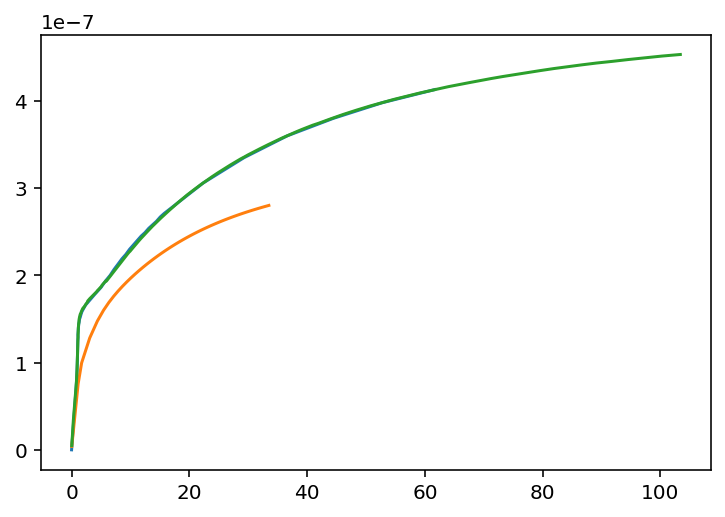

In [171]:
kmom2T = [0.0, 5.40e-8, 7.11e-8, 7.89e-8, 8.40e-8, 8.78e-8, 9.10e-8, 
                    9.38e-8, 9.62e-8, 9.84e-8, 1.01e-7, 1.09e-7, 1.15e-7, 1.20e-7, 
                    1.25e-7, 1.29e-7, 1.32e-7, 1.36e-7, 1.40e-7, 1.44e-7, 1.46e-7, 
                    1.50e-7, 1.52e-7, 1.55e-7, 1.58e-7, 1.60e-7, 1.62e-7, 1.64e-7, 
                    1.66e-7, 1.78e-7, 1.86e-7, 1.94e-7, 2.00e-7, 2.07e-7, 2.13e-7, 
                    2.19e-7, 2.24e-7, 2.30e-7, 2.35e-7, 2.40e-7, 2.45e-7, 2.49e-7, 
                    2.54e-7, 2.58e-7, 2.62e-7, 2.67e-7, 2.71e-7, 3.06e-7, 3.35e-7, 
                    3.60e-7, 3.80e-7, 3.98e-7, 4.13e-7]
plt.plot(abc_energy, kmom2T)
plt.plot(energies, np.array(kmom_bolos) )
plt.plot(sbs_energy, sbs_mom)

In [172]:
# compare the eedf from the bolsig run to the bolos run:
bolsig_eedf = np.loadtxt('run6_eedf.lut')  # this has mean energy of 5.28, E/N=204.2 Td

In [173]:
red_field_values[5]

204.2

In [174]:
sol_new = solvers[5]
f_new = solutions[5]
e_new = energies[5]

In [175]:
e_new

5.429816994305589

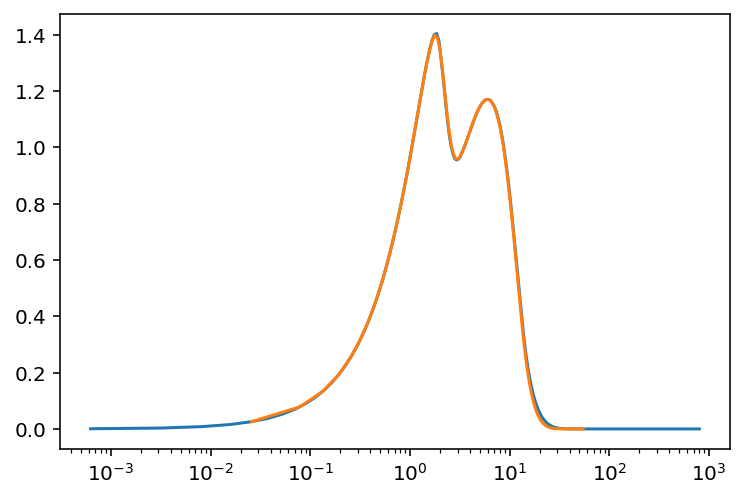

In [176]:
plt.semilogx(sol_new.grid.c,sol_new.grid.c* f_new/f_new[0], '-')
plt.semilogx(bolsig_eedf[:,0], bolsig_eedf[:,0]*bolsig_eedf[:,1]/bolsig_eedf[0,1])

In [177]:
kmom_bolos[5]

1.6005780792092956e-07

In [178]:
1.7588e11/sol_new.mobility(f_new)  # e/m in SI units = 1.7588e11

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)


1.9186203346958901e-13

In [179]:
kmom_bolos = []
nutot_bolos = []
for sol_new, f_new in zip(solvers, solutions):
    tmp = 0
    # for target, proc in sol_new.iter_elastic():
    for target, proc in sol_new.iter_momentum():
        tmp += sol_new.rate(f_new, proc)
    nutot_bolos.append(tmp * 1e6)
    kmom_bolos.append(1.7588e11/sol_new.mobility(f_new))

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergy

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:-2])
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:653: RuntimeWarning: invalid value encountered in log
  g = np.log(Fp[2:] / Fp[:-2]) / (cenergyp[2:] - cenergyp[:

/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np.sqrt(self.benergy)
/Users/asrich/anaconda/envs/rigid-beam/lib/python3.8/site-packages/bolos/solver.py:761: RuntimeWarning: divide by zero encountered in true_divide
  sigma_tilde = self.sigma_m + nu / np

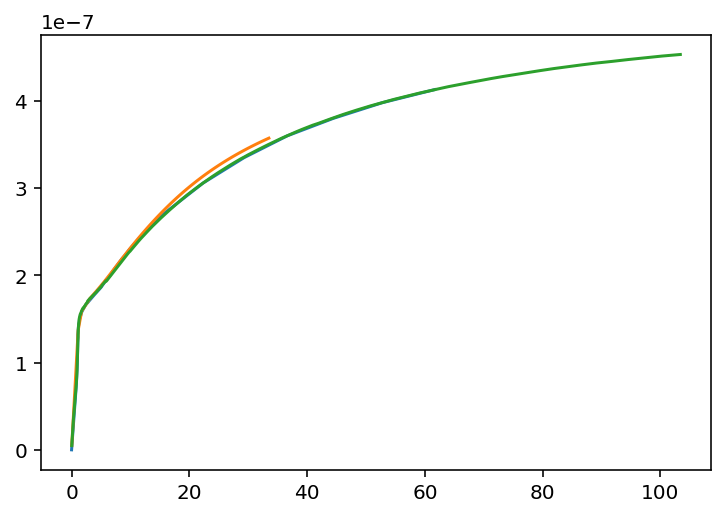

In [180]:
plt.plot(abc_energy, kmom2T)
plt.plot(energies, np.array(kmom_bolos) * 1e6 )
plt.plot(sbs_energy, sbs_mom)